In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras
from keras_tuner import HyperParameters

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Loading split data...
Split data loaded successfully!


In [6]:
def build_caffe_net(hp: HyperParameters):
    model = keras.models.Sequential(name="CaffeNet")

    model.add(
        keras.layers.Conv2D(
            filters=hp.Int("conv_1_filters", min_value=3, max_value=32, step=1),
            kernel_size=(11, 11),
            activation="relu",
            input_shape=preprocessing_utils.images.shape[1:],
        )
    )
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.BatchNormalization())

    additional_conv_layers = hp.Int("additional_conv_layers", 1, 3)

    for i in range(additional_conv_layers):  # type: ignore
        model.add(
            keras.layers.Conv2D(
                filters=hp.Int(
                    f"conv_{i+2}_filters", min_value=16, max_value=96, step=16
                ),
                kernel_size=(3, 3),
                activation="relu",
            )
        )
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(keras.layers.BatchNormalization())

    model.add(
        keras.layers.Conv2D(
            filters=hp.Int(f"conv_{additional_conv_layers+1}_filters", min_value=128, max_value=384, step=64),  # type: ignore
            kernel_size=(3, 3),
            activation="relu",
        )
    )
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Flatten())

    for i in range(2):
        model.add(
            keras.layers.Dense(
                units=hp.Int(
                    f"dense_{i+1}_units", min_value=512, max_value=2048, step=512
                ),
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
            )
        )

    model.add(
        keras.layers.Dense(units=preprocessing_utils.num_classes, activation="softmax")
    )

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),  # type: ignore
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
caffe_net_wrapper = ModelWrapper("CaffeNet", preprocessing_utils=preprocessing_utils)

In [8]:
caffe_net_wrapper.build_model(
    build_fn=build_caffe_net, model_name=caffe_net_wrapper.model_name
)

Removing previous random search results...
Initializing random search...
Model: "CaffeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 3)       1092      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 3)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                               

In [9]:
caffe_net_wrapper.train_and_save_model_and_history()

Trial 10 Complete [00h 04m 00s]
val_loss: 4.3370771408081055

Best val_loss So Far: 3.7961819171905518
Total elapsed time: 00h 41m 30s
INFO:tensorflow:Oracle triggered exit
Training final model...
Model: "CaffeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 246, 246, 9)       3276      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 123, 123, 9)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 123, 123, 9)      36        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 121, 121, 48)      3936      
                                                           

In [10]:
caffe_net_wrapper.load_model_and_history()

Loading model from "../../artifacts/checkpoints/checkpoint_CaffeNet.h5"...
Model loaded successfully!
Loading history from "../../artifacts/model_histories/history_CaffeNet"...
History loaded successfully!


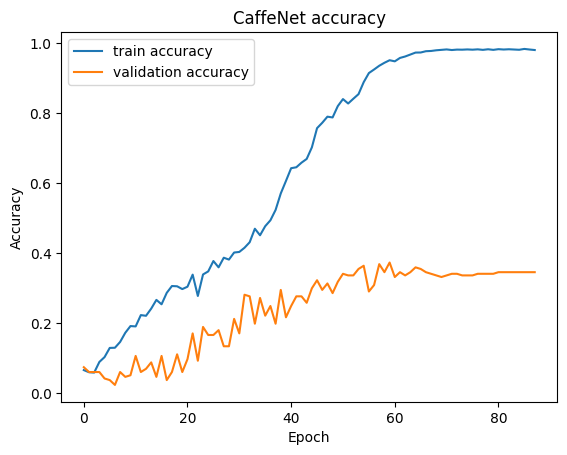

In [11]:
caffe_net_wrapper.plot_accuracy()

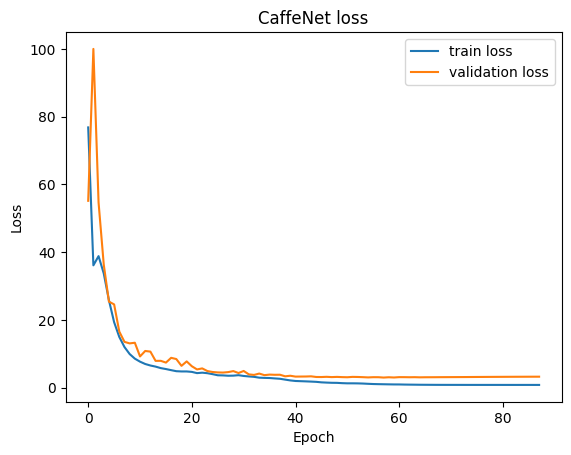

In [12]:
caffe_net_wrapper.plot_loss()

20/20 [==============================] - 0s 8ms/step - loss: 3.3318 - accuracy: 0.3296
Loss: 3.3318
Accuracy: 0.3296
20/20 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.04      0.06        23
           1       0.32      0.24      0.27        25
           2       0.45      0.58      0.51        52
           3       0.17      0.16      0.16        38
           4       0.33      0.26      0.29        27
           5       0.41      0.31      0.35        35
           6       0.23      0.24      0.24        45
           7       0.24      0.40      0.30        10
           8       0.38      0.50      0.43        12
           9       0.22      0.36      0.28        11
          10       0.50      0.26      0.34        23
          11       0.50      0.35      0.41        26
          12       0.23      0.28      0.25        32
          13       0.27      0.40      0.32       

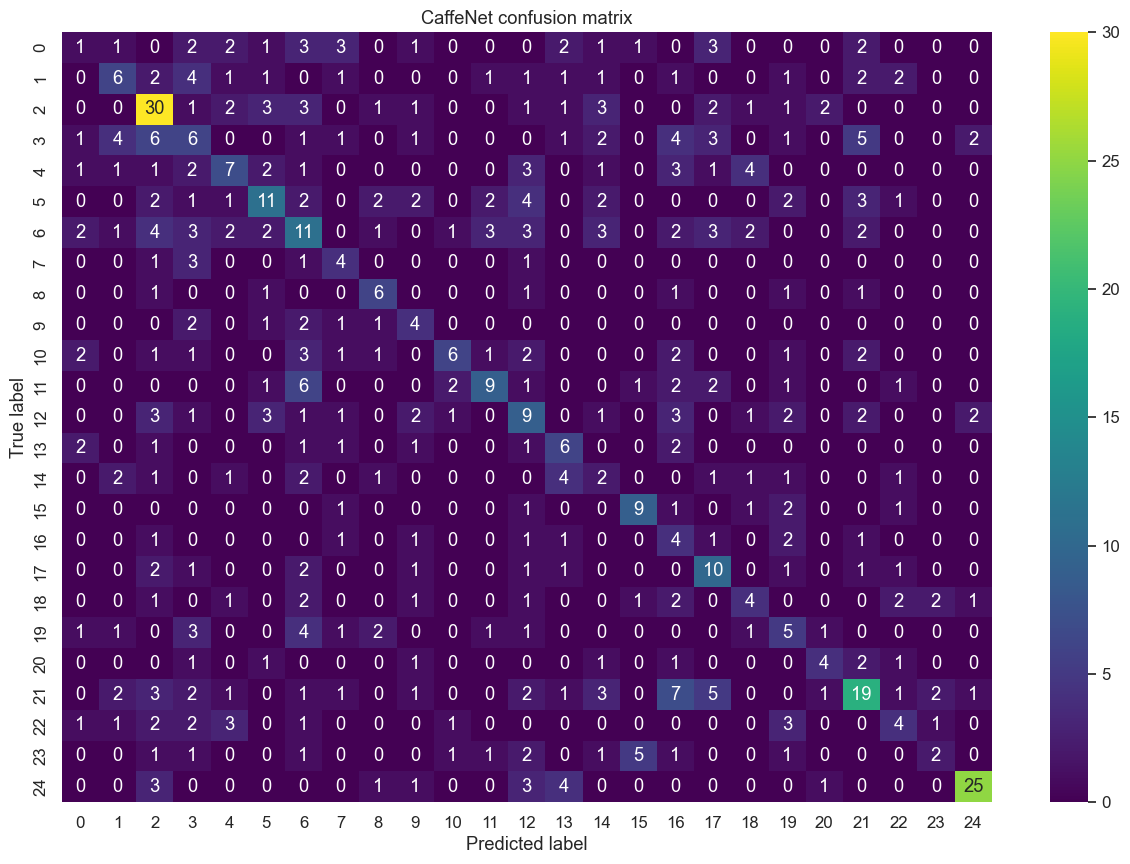

In [13]:
caffe_net_wrapper.display_evaluation_results()